# Cirq Interoperability

Cirq is a quantum SDK for explicitly addressing physical qubits and scheduling gates. You can consider it analogous to a quantum assembly language. Qualtran provides interoperability with Cirq.

In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit

from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature
from qualtran.drawing import show_bloq

## Using Cirq gates from Bloqs

 - `CirqGateAsBloq(gate)` lets you use any Cirq gate in your composite bloqs.
 - `CompositeBloq.from_cirq_circuit(circuit)` lets you turn any Cirq circuit into an equivalent `CompositeBloq`. Each subbloq will be a `CirqGateAsBloq` wrapper.

### `CirqGateAsBloq`

This wrapper uses the Cirq "calling convention" of one thru-register composted of a 1d array of qubits.

In [2]:
from qualtran.cirq_interop import CirqGateAsBloq

cgab = CirqGateAsBloq(cirq.QuantumFourierTransformGate(num_qubits=5))
print(cgab)
for reg in cgab.signature:
    print(' ', reg)

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CirqGateAsBloq(gate=cirq.QuantumFourierTransformGate(num_qubits=5, without_reverse=False))
  Register(name='qubits', bitsize=1, shape=(5,), side=<Side.THRU: 3>)


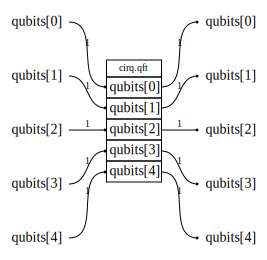

In [3]:
show_bloq(cgab)

### `CompositeBloq.from_cirq_circuit`

A Cirq circuit can be converted to a composite bloq by wrapping each operation with the `CirqGateAsBloq` wrapper. 

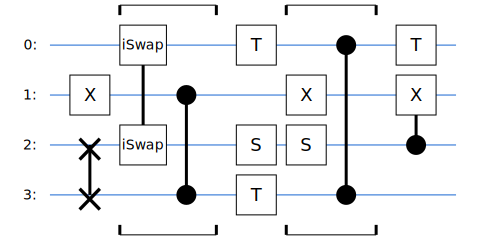

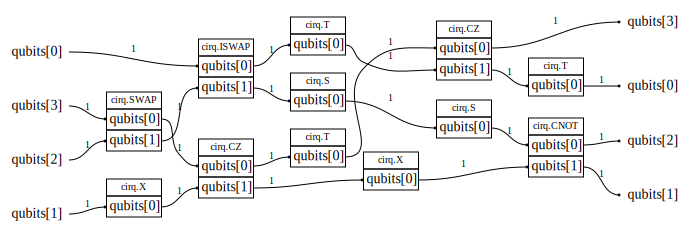

In [4]:
# Make a random cirq circuit
qubits = cirq.LineQubit.range(4)
circuit = cirq.testing.random_circuit(qubits, n_moments=5, op_density=1.0, random_state=52)

# Convert to CompositeBloq
cbloq = CompositeBloq.from_cirq_circuit(circuit)
display(SVGCircuit(circuit))
show_bloq(cbloq)

### Unitaries

Both containers support numerical contraction to a dense unitary matrix. Cirq contracts operations in order. Bloqs use `quimb` to find a good contraction ordering and perform the contraction. 

In [5]:
import numpy as np

bloq_unitary = cbloq.tensor_contract()
cirq_unitary = circuit.unitary(qubits)
np.testing.assert_allclose(cirq_unitary, bloq_unitary, atol=1e-8)

### Back to `cirq.Circuit`

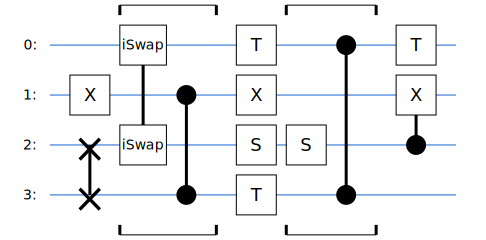

In [6]:
# Note: a 1d `shape` bloq register is actually two-dimensional in cirq conversion
# because of the implicit `bitsize` dimension (which must be explicit during cirq conversion).
# CirqGateAsBloq has registers of bitsize=1 and shape=(n,); hence the list transpose below.
circuit2, _ = cbloq.to_cirq_circuit(qubits=[[q] for q in qubits], qubit_manager=cirq.ops.SimpleQubitManager())
SVGCircuit(circuit2)

In [7]:
# We lose the moment structure during the roundtrip.
circuit == circuit2

False

In [8]:
# But the left-aligned `circuit` is recovered.
cirq.Circuit(circuit.all_operations()) == circuit2

True

# Importing Cirq-FT algorithms to Bloqs
`CirqGateAsBloq` also supports wrapping Cirq-FT's `GateWithRegisters` objects. As an example, we show how you can directly import `SELECT` and `PREPARE` primitives for the 2D Hubbard model from Cirq-FT into Bloqs. 

In [9]:
import cirq_ft
from cirq_ft.algos.hubbard_model import SelectHubbard, PrepareHubbard
import cirq_ft.infra.testing as cq_testing
x_dim, y_dim, t = 2, 2, 5
mu = 4 * t
# SELECT and PREPARE for 2D Hubbard Model
prepare = cq_testing.GateHelper(PrepareHubbard(x_dim=x_dim, y_dim=x_dim, t=t, mu=mu))
select = cq_testing.GateHelper(SelectHubbard(x_dim=x_dim, y_dim=y_dim, control_val=1))

                                                  ┌─────┐
U: ────────────────────────────────────────────────────@────────────────
                                                       │
V: ──────────────@──────@──────@───────────@───────@───┼────@──────@────
                 │      │      │           │       │   │    │      │
alpha: ─────In───┼──────┼──────×(x)────────×(x)────┼───┼────┼──────┼────
            │    │      │      │           │       │   │    │      │
beta: ──────┼────┼──────┼──────×(y)───In───×(y)────┼───┼────┼──────┼────
            │    │      │             │            │   │    │      │
control: ───@────┼──────┼─────────────@────S^-1────┼───@────┼──────@────
            │    │      │             │            │        │      │
p_x: ───────In───×(x)───┼─────────────┼────────────┼────────×(x)───┼────
            │    │      │             │            │        │      │
p_y: ───────In───┼──────×(x)──────────┼────────────×(x)─────┼──────┼────
            │    │      │    

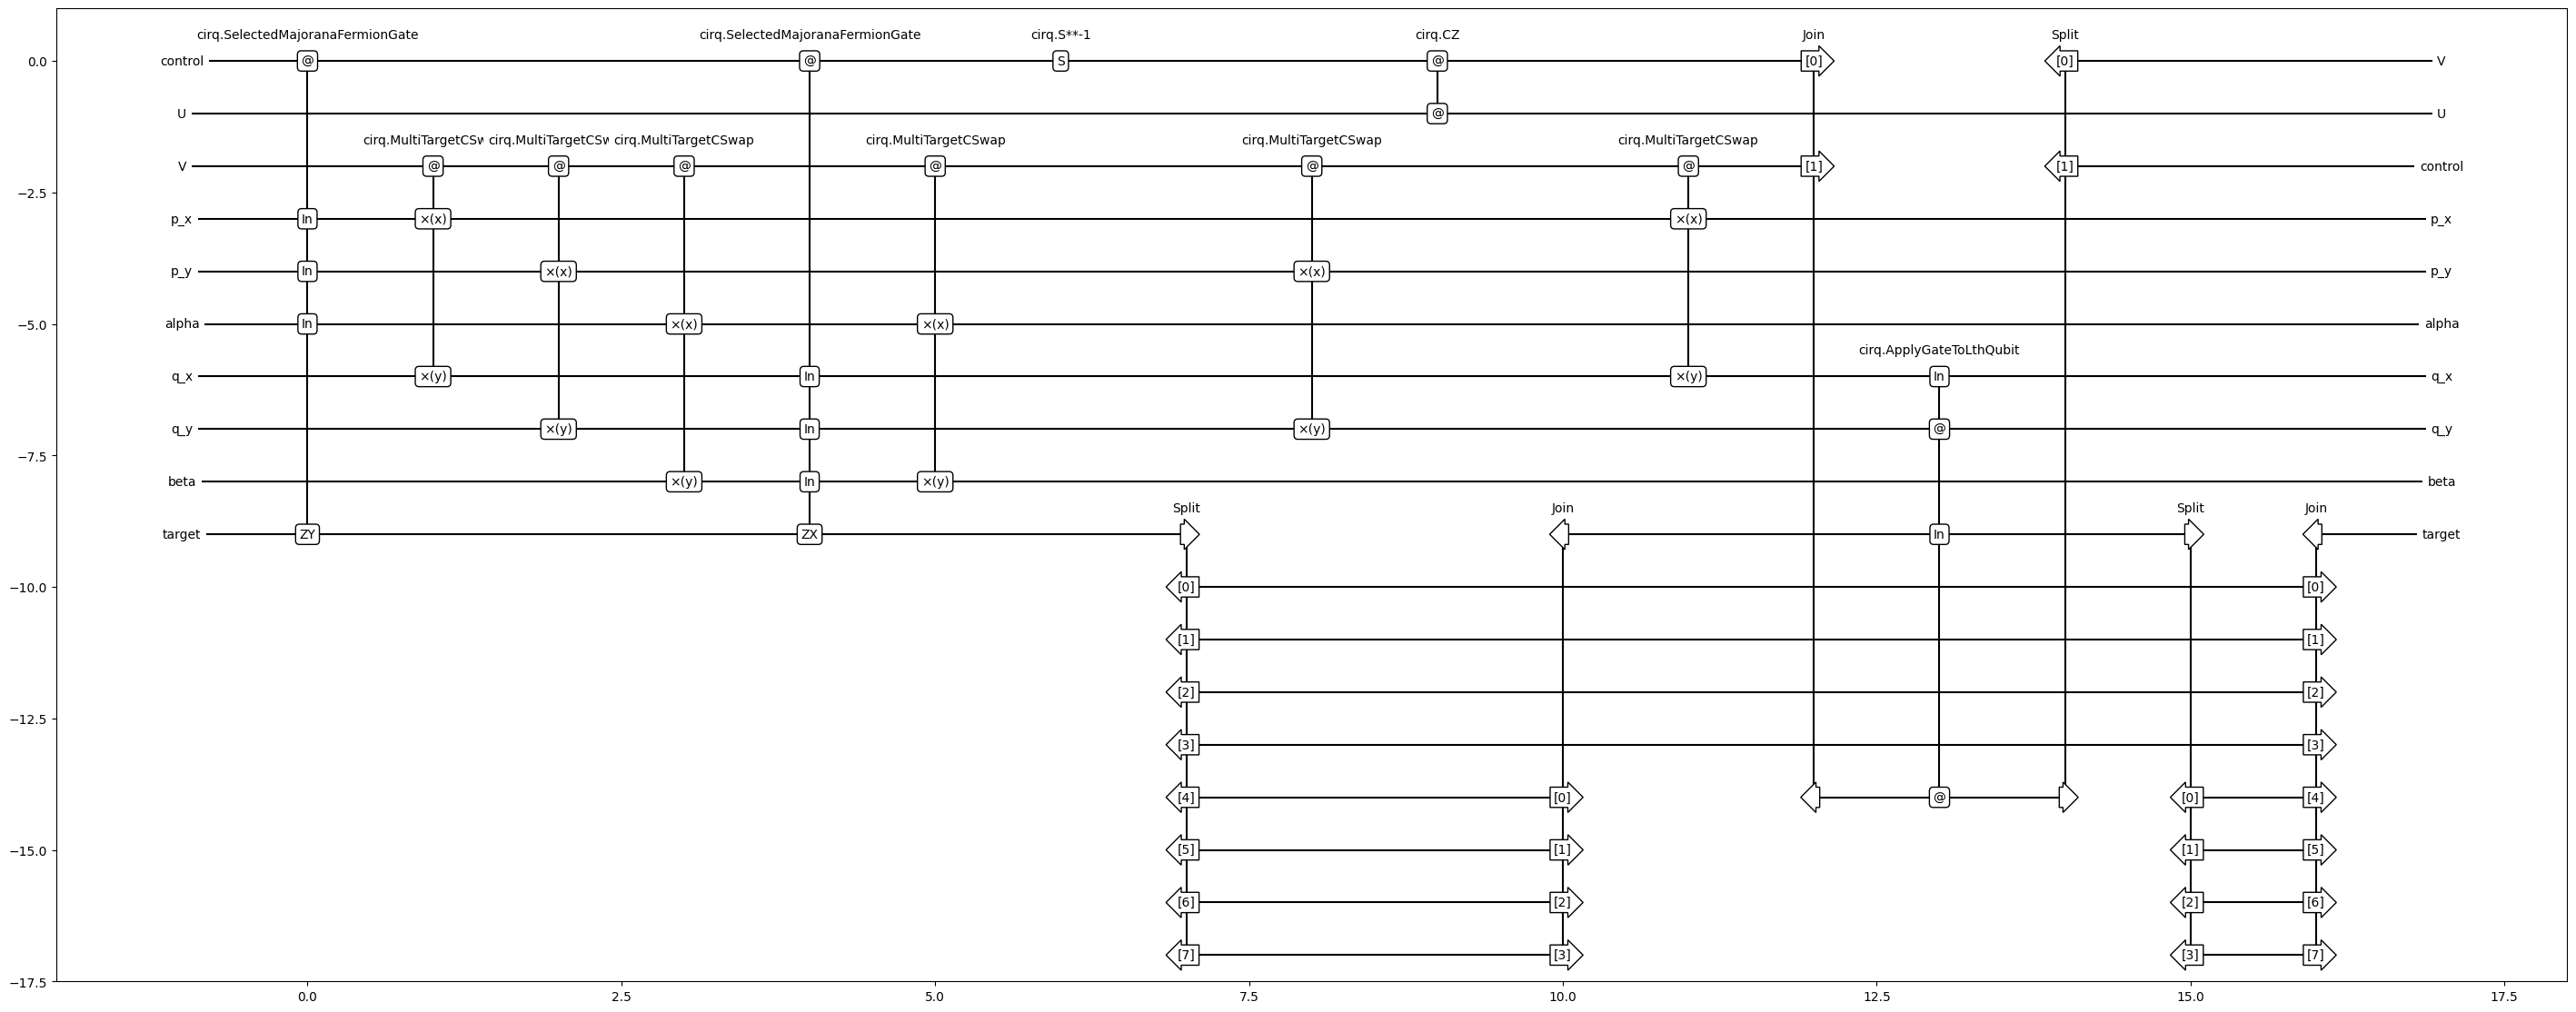

In [10]:
from qualtran.drawing.musical_score import get_musical_score_data, draw_musical_score
print(cirq.Circuit(cirq.decompose_once(select.operation)))
bloq = CirqGateAsBloq(select.gate)
fig, ax = draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))
fig.set_size_inches(30, 12)
assert bloq.t_complexity() == cirq_ft.t_complexity(select.gate)

                                            ┌───────────┐                                        ┌───────┐
_decompose_protocol_1_c(0): ──────────────────────────────────────────────────────────────────────────And────@──────And†───
                                                                                                      │      │      │
_decompose_protocol_1_c(1): ──────────────────────────────────────────────────────────────────────────Anc────┼──────Anc────
                                                                                                      │      │      │
U: ──────────────────────────────────────────Ry(0.705π)─────@──────────────────────@(0)───────────────(0)────┼──────(0)────
                                             │              │                      │                  │      │      │
V: ────────────────────────────Ry(0.667π)────@──────────────X──────X───@───@───X───@(0)───────────────(0)────┼──────(0)────
                                           

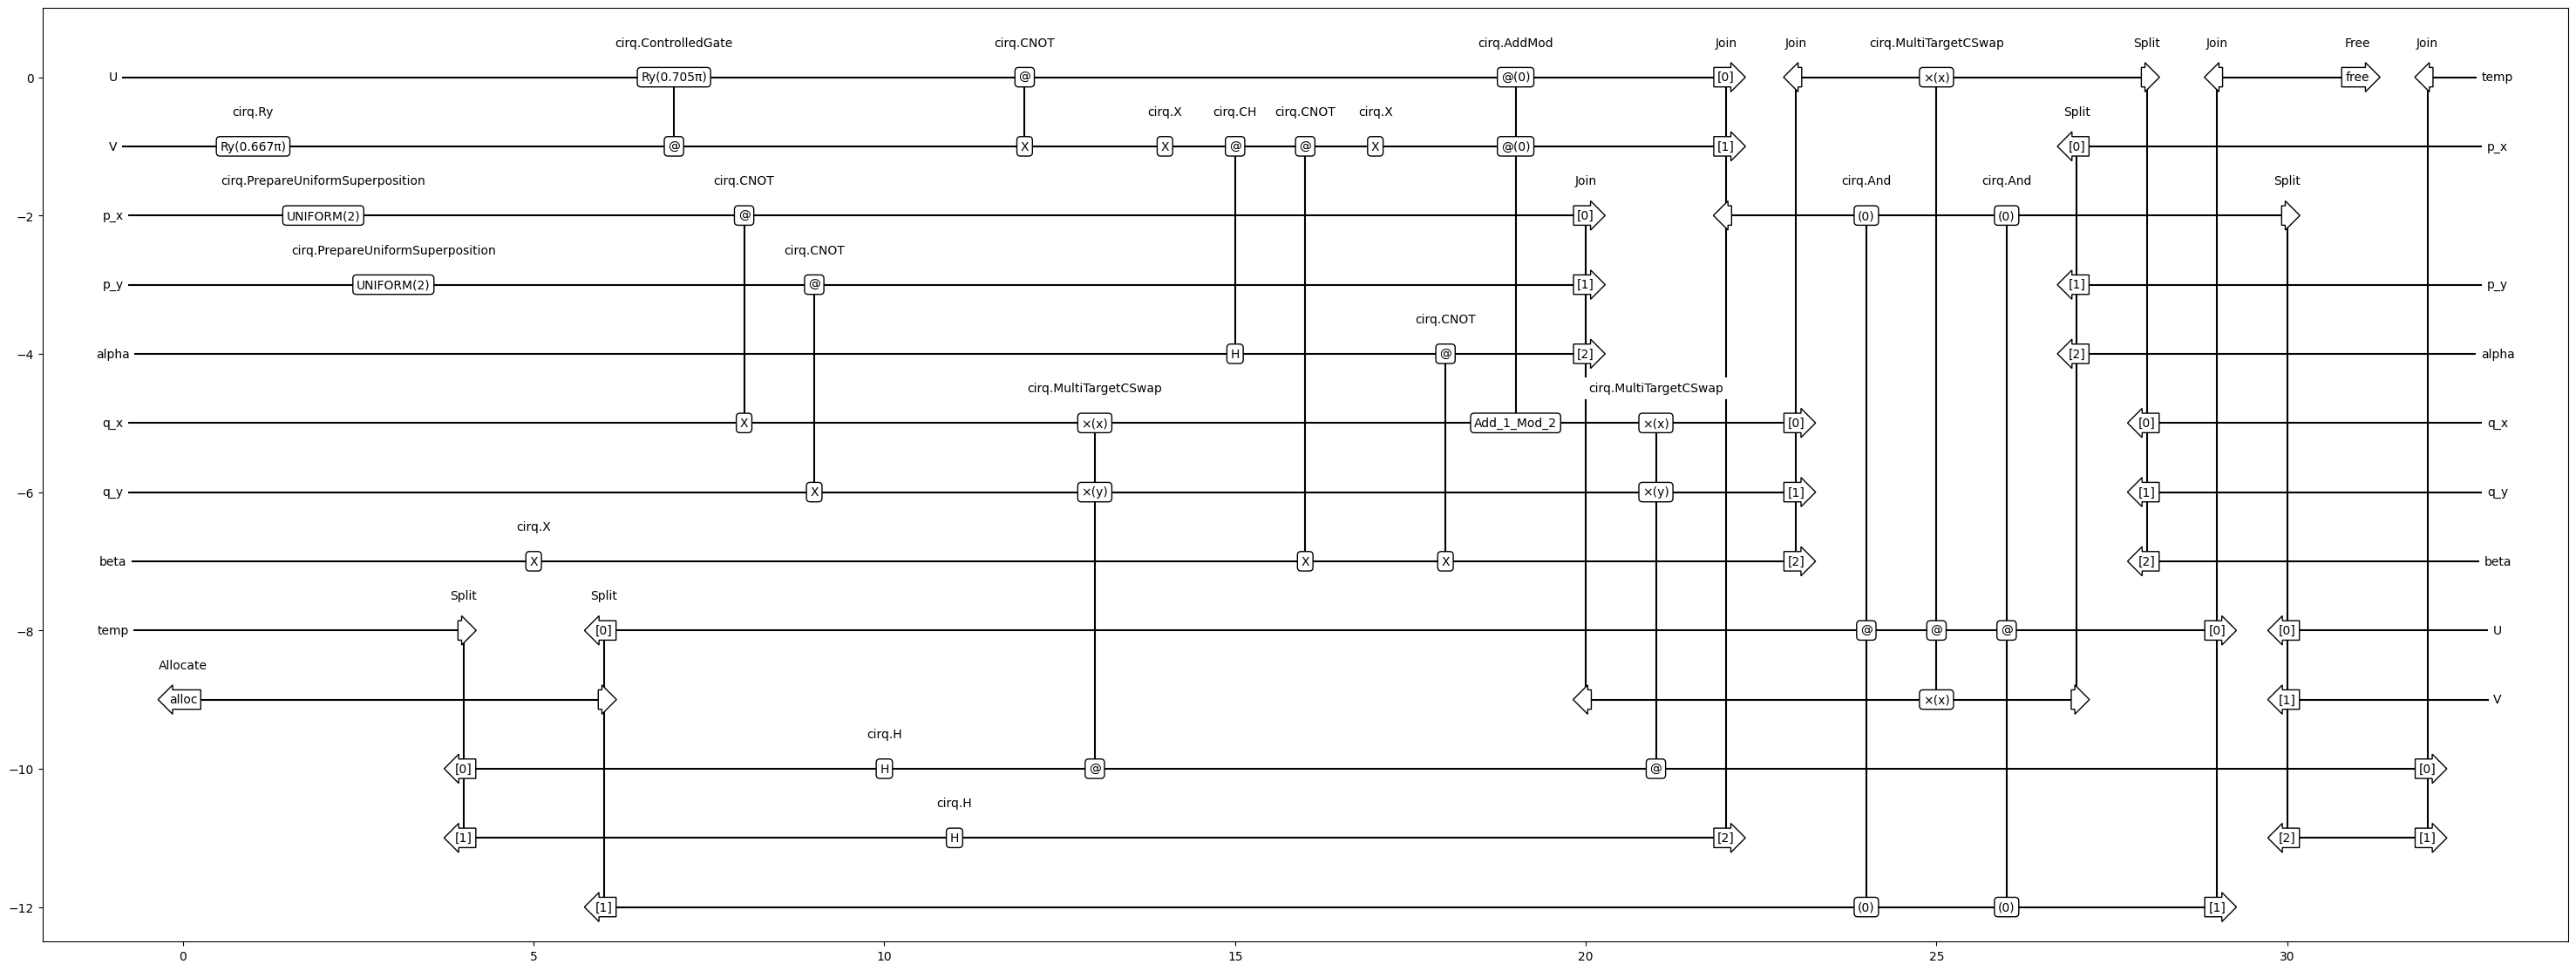

In [11]:
print(cirq.Circuit(cirq.decompose_once(prepare.operation)))
bloq = CirqGateAsBloq(prepare.gate)
fig, ax = draw_musical_score(get_musical_score_data(bloq.decompose_bloq()))
fig.set_size_inches(30, 12)
assert bloq.t_complexity() == cirq_ft.t_complexity(prepare.gate)

## Converting Bloqs to Cirq objects

 - `Bloq.as_cirq_op` is an overridable method to declare what cirq operation corresponds to a bloq.
 - `CompositeBloq.to_cirq_circuit` will export a CompositeBloq to a cirq circuit.
 - `BloqAsCirqGate` provides a shim for using bloqs in cirq circuits automatically.

### `as_cirq_op` 

Bloqs can override `as_cirq_op` to optionally declare their corresponding Cirq operation. For example, the `SwapTwoBits` bloqs from the tutorial corresponds to `cirq.SWAP`.

The bloqs infrastructure will call `as_cirq_op` with keyword arguments mapping register names to `np.ndarray`s of `cirq.Qid` whose shape is `reg.shape + (reg.bitsize,)`. The type alias `CirqQuregT` is provided for convenience.

The method must return both the Cirq operation as well as a mapping from right register names to arrays of output `cirq.Qid`. This is to permit the use of `cirq_ft.infra.qubit_manager` allocation facilities.

In [12]:
import attrs
from typing import *

from qualtran.cirq_interop import CirqQuregT

@attrs.frozen
class SwapTwoBits(Bloq):
    @property
    def signature(self):
        return Signature.build(x=1, y=1)
    
    def as_cirq_op(
            self, qubit_manager, x: CirqQuregT, y: CirqQuregT
    ) -> Tuple[cirq.Operation, Dict[str, CirqQuregT]]:
        x, = x  # each is an array of length one
        y, = y
        op = cirq.SWAP(x, y)
        out_quregs = {'x': [x], 'y': [y]}
        return op, out_quregs

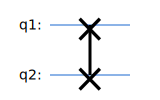

In [13]:
circuit, out_quregs = SwapTwoBits().as_composite_bloq()\
    .to_cirq_circuit(x=[cirq.NamedQubit('q1')], y=[cirq.NamedQubit('q2')])
SVGCircuit(circuit)

### `CompositeBloq.to_cirq_circuit`

A composite bloq can be turned into a circuit composed of the result of `as_cirq_op` for each of the subbloqs.

A bloq's `Signature` has a helper method to instantiate Cirq qubits in the correct form for input to the function.

In [14]:
SwapTwoBits().signature.get_cirq_quregs()

{'x': array([cirq.NamedQubit('x')], dtype=object),
 'y': array([cirq.NamedQubit('y')], dtype=object)}

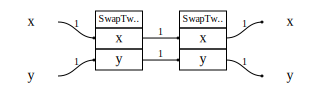

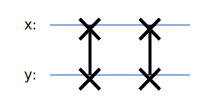

In [15]:
# Build a simple composite bloq
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
cbloq = bb.finalize(x=x, y=y)

# Turn it into a cirq circuit
quregs = cbloq.signature.get_cirq_quregs()
circuit, _ = cbloq.to_cirq_circuit(**quregs)

# Observe
show_bloq(cbloq)
display(SVGCircuit(circuit))

### `BloqAsCirqGate`

The default behavior of `as_cirq_op` will shim the bloq into this object which lets you use a bloq in cirq circuits.

Below, we reproduce the multi-bit swap from the tutorial. This time, we do not implement `as_cirq_op` ourselves. This is appropriate if there isn't an equivalent gate in Cirq, which is likely the case for high-level bloqs.

In [16]:
@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: 'BloqBuilder', *, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        xs = bb.split(x)
        ys = bb.split(y)
        for i in range(self.n):
            xs[i], ys[i] = bb.add(SwapTwoBits(), x=xs[i], y=ys[i])
        return {'x': bb.join(xs), 'y': bb.join(ys)}

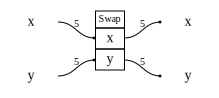

In [17]:
swap = Swap(n=5)
show_bloq(swap)

Instead, we get a `BloqAsCirqGate` by default.

In [18]:
circuit, _ = swap.as_composite_bloq().to_cirq_circuit(
    x=cirq.LineQubit.range(5), y=cirq.LineQubit.range(100,105))

op = next(circuit.all_operations())
op.gate

BloqAsCirqGate(Swap(n=5))

This wrapper can delegate cirq `decompose` calls to bloq decomposition. If the bloqs in the decomposition have native `as_cirq_op` operations, then we successfully have a standard Cirq circuit.

In [19]:
swap_decomp_circuit = cirq.Circuit(cirq.decompose_once(op))
print(repr(swap_decomp_circuit))

cirq.Circuit([
    cirq.Moment(
        cirq.SWAP(cirq.LineQubit(0), cirq.LineQubit(100)),
        cirq.SWAP(cirq.LineQubit(1), cirq.LineQubit(101)),
        cirq.SWAP(cirq.LineQubit(2), cirq.LineQubit(102)),
        cirq.SWAP(cirq.LineQubit(3), cirq.LineQubit(103)),
        cirq.SWAP(cirq.LineQubit(4), cirq.LineQubit(104)),
    ),
])


In [20]:
import cirq_ft.infra.testing as cq_testing
from cirq_ft.infra.jupyter_tools import display_gate_and_compilation

g = cq_testing.GateHelper(op.gate)
display_gate_and_compilation(g, include_costs=False)

### Allocation and de-allocation

Cirq conversion can allocate and deallocate qubits with the help of `cirq_ft.infra.qubit_manager` tools. As an example, we look at the `MultiAnd` bloq. Behind the scenes, this uses the default `BloqAsCirqGate` shim which will allocate the target and junk right-only registers automatically.

In [21]:
from qualtran.bloqs.and_bloq import MultiAnd

multi_and = MultiAnd(cvs=(1, 1, 1, 1))

Our input Cirq qubit registers include just the control qubits.

In [22]:
cirq_quregs = multi_and.signature.get_cirq_quregs()
cirq_quregs

{'ctrl': array([[cirq.NamedQubit('ctrl[0]')],
        [cirq.NamedQubit('ctrl[1]')],
        [cirq.NamedQubit('ctrl[2]')],
        [cirq.NamedQubit('ctrl[3]')]], dtype=object)}

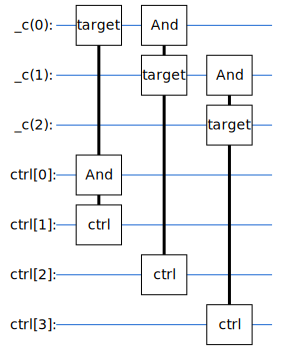

In [23]:
multi_and_circuit, out_quregs = multi_and.decompose_bloq().to_cirq_circuit(**cirq_quregs)
SVGCircuit(multi_and_circuit)

The second return value of `as_cirq_op` and `to_cirq_circuit` is the output cirq qubit registers that we can use to identify allocated qubits.

In [24]:
# Note the new precense of `junk` and `target` entries.
out_quregs

{'ctrl': array([[cirq.NamedQubit('ctrl[0]')],
        [cirq.NamedQubit('ctrl[1]')],
        [cirq.NamedQubit('ctrl[2]')],
        [cirq.NamedQubit('ctrl[3]')]], dtype=object),
 'junk': array([[cirq.ops.CleanQubit(0)],
        [cirq.ops.CleanQubit(1)]], dtype=object),
 'target': array([cirq.ops.CleanQubit(2)], dtype=object)}